# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](https://github.com/hse-ds/iad-intro-ds/blob/master/2023/homeworks/hw07-trees/meme.jpg?raw=1) -->
<img src="https://github.com/hse-ds/iad-intro-ds/blob/master/2023/homeworks/hw07-trees/meme.jpg?raw=1" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
def H(p=int):
   return(-(p*np.log(p) + (1-p)*np.log(1-p)))
H(0.8)

0.5004024235381879

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def H(p=int):
   return((p*(1-p) + (1-p)*(p)))
Q = H(0.8) - 8/10*H(1)-2/10*H(1)
Q

0.31999999999999995

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [50]:
from typing import Union, List

def find_best_split(
    feature_vector: np.ndarray,
    target: np.ndarray,
    task: str,
    feature_type: str
) -> Union[float, int, np.ndarray, np.ndarray]:
    if task == "regression":
        return find_best_split_regression(feature_vector, target, feature_type)
    elif task == "classification":
        return find_best_split_classification(feature_vector, target, feature_type)
    else:
        raise ValueError("Unknown task")

def find_best_split_regression(
    feature_vector: np.ndarray,
    target: np.ndarray,
    feature_type: str
) -> Union[float, int, np.ndarray, np.ndarray]:
    thresholds = np.unique(feature_vector)
    errors = np.zeros_like(thresholds)

    for i, threshold in enumerate(thresholds):
        left_indices = feature_vector <= threshold
        right_indices = feature_vector > threshold

        if feature_type == "categorical":
            left_std = np.std(target[left_indices])
            right_std = np.std(target[right_indices])
        else:
            left_std = np.std(target[left_indices], ddof=1)
            right_std = np.std(target[right_indices], ddof=1)

        errors[i] = left_std + right_std

    best_index = np.argmin(errors)
    best_threshold = thresholds[best_index]

    return errors[best_index], best_threshold, thresholds, errors

def find_best_split_classification(
    feature_vector: np.ndarray,
    target: np.ndarray,
    feature_type: str
) -> Union[float, int, np.ndarray, np.ndarray]:
    thresholds = np.unique(feature_vector)
    errors = np.zeros_like(thresholds)

    for i, threshold in enumerate(thresholds):
        left_indices = feature_vector <= threshold
        right_indices = feature_vector > threshold

        left_counts = np.bincount(target[left_indices])
        right_counts = np.bincount(target[right_indices])

        left_gini = 1.0 - np.sum((left_counts / np.sum(left_counts)) ** 2)
        right_gini = 1.0 - np.sum((right_counts / np.sum(right_counts)) ** 2)

        errors[i] = left_gini + right_gini

    best_index = np.argmin(errors)
    best_threshold = thresholds[best_index]

    return errors[best_index], best_threshold, thresholds, errors

Эту функцию можно протестировать на датасете `California`.

In [30]:
from sklearn.datasets import fetch_california_housing

In [31]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [32]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


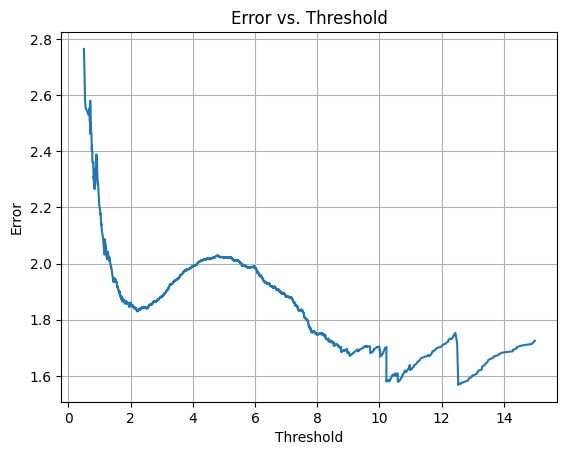

In [54]:
import matplotlib.pyplot as plt

data = fetch_california_housing()
feature_vector = X.iloc[:,0]
target_vector = y

best_threshold, best_error, thresholds, errors = find_best_split(feature_vector, target_vector, task="regression", feature_type='real')

plt.plot(thresholds, errors)
plt.xlabel('Threshold')
plt.ylabel('Error')
plt.title('Error vs. Threshold')
plt.grid(True)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

> Ну вот 10-13 норм




In [61]:
data = {'thresholds': thresholds, 'error': errors}
df = pd.DataFrame(data)

df_sorted = df.sort_values(by='error', ascending=True)
df_sorted

,thresholds,error
12883,12.5381,1.568024
12884,12.5420,1.570446
12886,12.5915,1.570751
12885,12.5902,1.572904
12887,12.6320,1.573274
...,...,...
11,0.7054,2.558062
10,0.7025,2.580166
1,0.5360,2.581554
0,0.4999,2.764604


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [14]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        
        self._feature_types = feature_types
        
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        self._feature_importances = {}
        

    def _fit_node(
    self,
    sub_X: np.ndarray,
    sub_y: np.ndarray,
    node: dict
    ) -> None:

        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError("Unknown feature type")

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError("Unknown feature type")

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
    
        if node["type"] == "terminal":
            return node["class"]

        feature_split = node["feature_split"]
        feature_type = self._feature_types[feature_split]

        if feature_type == "real":
            threshold = node["threshold"]
            if x[feature_split] <= threshold:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif feature_type == "categorical":
            category_split = node["category_split"]
            if x[feature_split] == category_split:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError("Unknown feature type")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [16]:
def find_threshold_gini(feature, target):
    unique_values = np.unique(feature)
    thresholds = (unique_values[:-1] + unique_values[1:]) / 2
    ginis = []
    
    for threshold in thresholds:
        left_mask = feature <= threshold
        right_mask = ~left_mask
        
        left_classes, left_counts = np.unique(target[left_mask], return_counts=True)
        right_classes, right_counts = np.unique(target[right_mask], return_counts=True)
        
        left_probs = left_counts / np.sum(left_counts)
        right_probs = right_counts / np.sum(right_counts)
        
        left_gini = 1 - np.sum(left_probs ** 2)
        right_gini = 1 - np.sum(right_probs ** 2)
        
        gini_index = (np.sum(left_counts) * left_gini + np.sum(right_counts) * right_gini) / len(target)
        ginis.append(gini_index)
    
    return thresholds, ginis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2023/homeworks/hw07-trees/students.csv')

features = data.iloc[:, 1:6]
target = data.iloc[:, -1]

plt.figure(figsize=(10, 8))
for feature in features.columns:
    thresholds, ginis = find_threshold_gini(features[feature], target)
    plt.plot(thresholds, ginis, label=feature)

plt.xlabel("Threshold")
plt.ylabel("Gini Index")
plt.legend()
plt.title("Threshold - Gini Index Curves")
plt.show()

plt.figure(figsize=(10, 8))
for feature in features.columns:
    plt.scatter(features[feature], target, label=feature, alpha=0.5)

plt.xlabel("Feature Value")
plt.ylabel("Class")
plt.legend()
plt.title("Scatter Plots: Feature Value - Class")
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева?
> по пег

 Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? 
> да, он там четко разделяет 

 Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? 
 
> должен быть четкий экстремум

 Чем отличаются кривые для признаков, по которым деление практически невозможно?

> не должно быть четкого экстремума (плоские)


**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2023/homeworks/hw07-trees/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

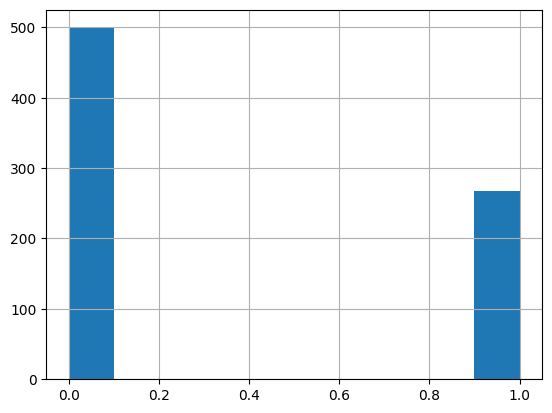

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

max_depth_values = [3, 4, 5, 6, 7, 9]
min_samples_leaf_values = [1, 3, 4, 5, 6, 7, 9, 12]

best_max_depth = None
best_min_samples_leaf = None

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(X_train, y_train)

        y_pred_val = clf.predict(X_val)
        f1 = f1_score(y_val, y_pred_val)

        if f1 > best_f1:
            best_f1 = f1
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf

clf = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
clf.fit(X_train, y_train)

y_pred_test = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
auc_roc = roc_auc_score(y_test, y_pred_test)

print("Лучшие гиперпараметры: max_depth =", best_max_depth, ", min_samples_leaf =", best_min_samples_leaf)
print("Качество классификации на тестовой выборке:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC:", auc_roc)

Лучшие гиперпараметры: max_depth = 5 , min_samples_leaf = 6
Качество классификации на тестовой выборке:
Accuracy: 0.7186147186147186
Precision: 0.5903614457831325
Recall: 0.6125
AUC-ROC: 0.6936672185430464


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(n_estimators=50)
bagging_clf.fit(X_train, y_train)

y_pred_test_bagging = bagging_clf.predict(X_test)
accuracy_bagging = accuracy_score(y_test, y_pred_test_bagging)
precision_bagging = precision_score(y_test, y_pred_test_bagging)
recall_bagging = recall_score(y_test, y_pred_test_bagging)
auc_roc_bagging = roc_auc_score(y_test, y_pred_test_bagging)

print("Качество классификации BaggingClassifier на тестовой выборке:")
print("Accuracy:", accuracy_bagging)
print("Precision:", precision_bagging)
print("Recall:", recall_bagging)
print("AUC-ROC:", auc_roc_bagging)

Качество классификации BaggingClassifier на тестовой выборке:
Accuracy: 0.7575757575757576
Precision: 0.6714285714285714
Recall: 0.5875
AUC-ROC: 0.717591059602649


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

max_depth_values = [3, 5, 7, 9, 11, 13]
min_samples_split_values = [2, 4, 6, 8]

best_f1_mean = 0
best_max_depth = None
best_min_samples_split = None

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rf_clf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split)
        
        f1_scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='f1')
        f1_mean = f1_scores.mean()

        if f1_mean > best_f1_mean:
            best_f1_mean = f1_mean
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split

best_rf_clf = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth, min_samples_split=best_min_samples_split)
best_rf_clf.fit(X_train, y_train)

y_pred_test_rf = best_rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
precision_rf = precision_score(y_test, y_pred_test_rf)
recall_rf = recall_score(y_test, y_pred_test_rf)
auc_roc_rf = roc_auc_score(y_test, y_pred_test_rf)

print("Лучшие гиперпараметры: max_depth =", best_max_depth, ", min_samples_split =", best_min_samples_split)
print("Качество классификации Random Forest на тестовой выборке:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("AUC-ROC:", auc_roc_rf)

Лучшие гиперпараметры: max_depth = 13 , min_samples_split = 6
Качество классификации Random Forest на тестовой выборке:
Accuracy: 0.7316017316017316
Precision: 0.625
Recall: 0.5625
AUC-ROC: 0.6918460264900662


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

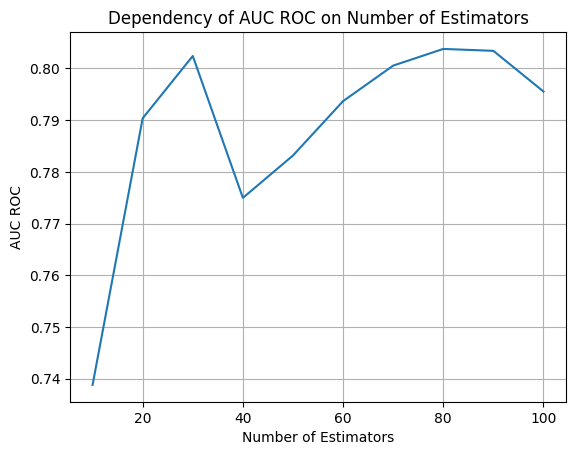

In [ ]:
n_estimators_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

auc_roc_scores = []

for n_estimators in n_estimators_values:
    rf_clf = RandomForestClassifier(n_estimators=n_estimators)
    rf_clf.fit(X_train, y_train)
    
    y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    auc_roc_scores.append(auc_roc)

plt.plot(n_estimators_values, auc_roc_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('AUC ROC')
plt.title('Dependency of AUC ROC on Number of Estimators')
plt.grid(True)
plt.show()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

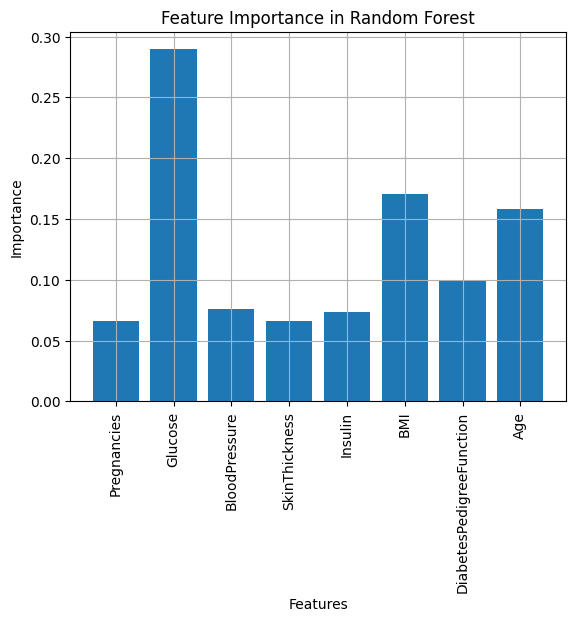

Самый важный признак для определения диабета: Glucose


In [ ]:
feature_importances = best_rf_clf.feature_importances_

feature_names = list(X_train.columns)

plt.bar(feature_names, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.show()

max_importance_index = np.argmax(feature_importances)

most_important_feature = feature_names[max_importance_index]
print("Самый важный признак:", most_important_feature)